YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Using column for closing prices: close_tsla
Epoch 1/50



e:\stock dashboard2\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0057
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.5813e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3367e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.2103e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4376e-04
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.8894e-04
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.7768e-04
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.4768e-04
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.2976e-04
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6363e-04
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9676e-04
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5234e-04
Epoch 13/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0225e-04
Epoch 14/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5298e-04
Epoch 15/50
46/46 ━━━━━━━━━━━━

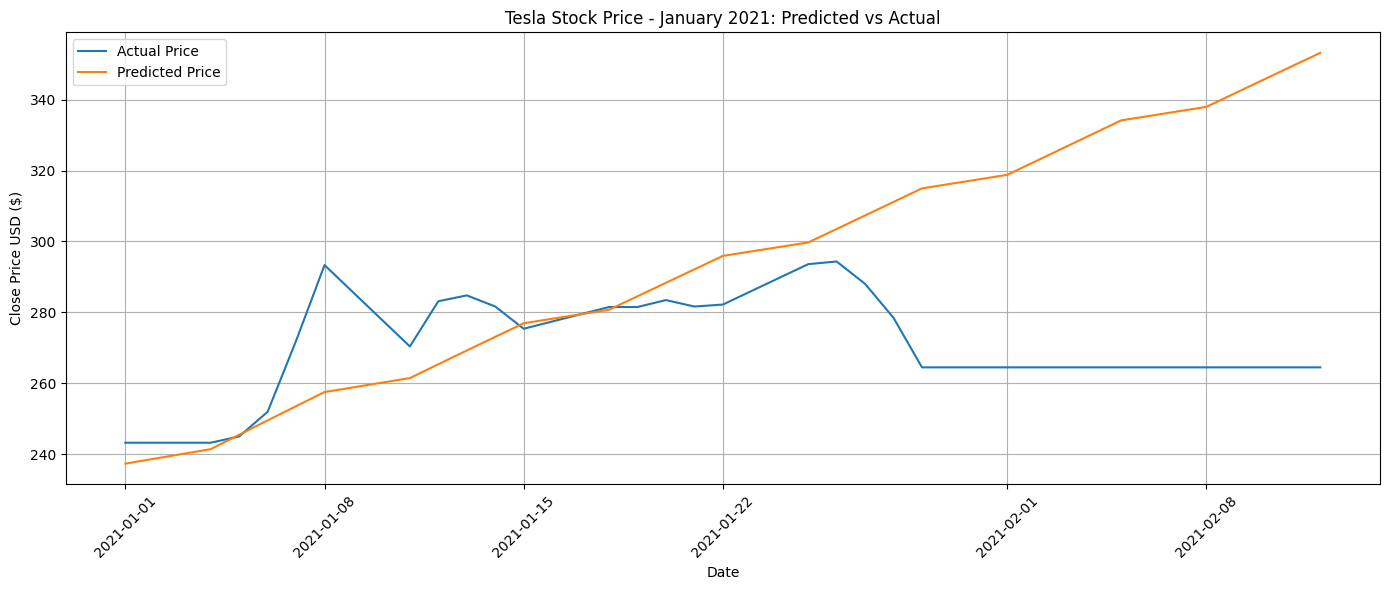

Forecast saved to 'tesla_jan_2021_pred_vs_actual.csv'
        Date  Predicted Price  Actual Price
0 2021-01-01       237.369995        243.26
1 2021-01-04       241.449997        243.26
2 2021-01-05       245.520004        245.04
3 2021-01-06       249.559998        251.99
4 2021-01-07       253.570007        272.01


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from datetime import timedelta

# Download Tesla stock data up to end of 2020 for training, and Jan 2021 for comparison
df = yf.download('TSLA', start='2015-01-01', end='2021-02-01')

# Handle MultiIndex columns
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip().lower() for col in df.columns.values]
else:
    df.columns = df.columns.str.strip().str.lower()

# Detect 'close' column
close_col = [col for col in df.columns if 'close' in col][0]
print(f"Using column for closing prices: {close_col}")

# Prepare data
df = df.dropna(subset=[close_col])
data = df[[close_col]].copy()
dataset = data.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Training data (up to Dec 31, 2020)
training_data_len = len(data[data.index <= '2020-12-31'])
train_data = scaled_data[0:training_data_len]

# Prepare training sequences
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build and train LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(60, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Prepare input for January 2021 prediction (last 60 days of 2020)
last_60_days = scaled_data[training_data_len-60:training_data_len]
future_input = last_60_days.reshape(1, 60, 1)
future_predictions = []

# Predict for 31 days (to cover all of January 2021)
for _ in range(31):
    pred = model.predict(future_input, verbose=0)[0][0]
    future_predictions.append(pred)
    future_input = np.append(future_input[:, 1:, :], [[[pred]]], axis=1)

# Inverse scale predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Generate January 2021 dates
last_date = pd.to_datetime('2020-12-31')
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=31, freq='B')

# Actual January 2021 data
jan_2021_actual = df[df.index >= '2021-01-01'][close_col].reindex(future_dates, method='nearest')

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions,
    'Actual Price': jan_2021_actual.values
}).round(2)

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(forecast_df['Date'], forecast_df['Actual Price'], label='Actual Price')
plt.plot(forecast_df['Date'], forecast_df['Predicted Price'], label='Predicted Price')
plt.title('Tesla Stock Price - January 2021: Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Export to CSV
forecast_df.to_csv("tesla_jan_2021_pred_vs_actual.csv", index=False)
print("Forecast saved to 'tesla_jan_2021_pred_vs_actual.csv'")
print(forecast_df.head())